In [ ]:
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
from tensorflow.keras.applications import (
    ResNet50, ResNet101, NASNetMobile, EfficientNetV2B0,
    DenseNet121, InceptionV3, Xception, MobileNetV2, VGG16, ResNet152V2
)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [ ]:
(x_train_full, y_train_full), (x_test_full, y_test_full) = tf.keras.datasets.cifar100.load_data(label_mode='fine')
selected_classes = list(range(20))
num_classes = len(selected_classes)

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [ ]:
train_mask = np.isin(y_train_full, selected_classes).flatten()
x_train = x_train_full[train_mask]
y_train = y_train_full[train_mask]

In [ ]:
def display_img(img_set, title_set):
  n = len(title_set)
  plt.figure(figsize=(10, 6))
  for i in range(n):
    plt.subplot(3, 3, i + 1)
    plt.imshow(img_set[i], cmap = 'gray')
    plt.title(title_set[i])
  plt.tight_layout()
  plt.show()
  plt.close()

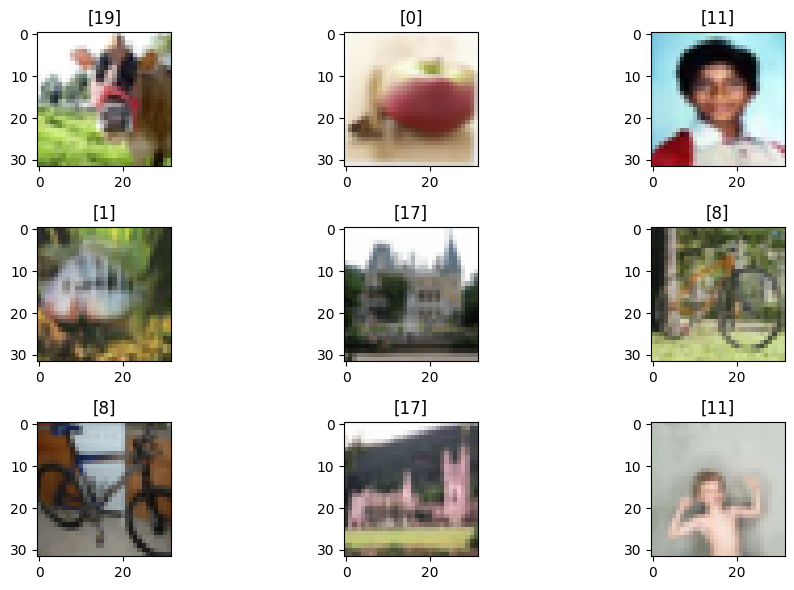

In [ ]:
display_img(x_train[:9], y_train[:9])

In [ ]:
label_mapping = {original: new for new, original in enumerate(selected_classes)}
y_train = np.vectorize(label_mapping.get)(y_train)
y_test = np.vectorize(label_mapping.get)(y_test)


In [ ]:
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

In [ ]:
models = [
    ('ResNet50', ResNet50),
    ('NASNetMobile', NASNetMobile),
    ('EfficientNetV2B0', EfficientNetV2B0),
    ('MobileNetV2', MobileNetV2),
    ('DenseNet121', DenseNet121),
    ('InceptionV3', InceptionV3),
    ('Xception', Xception),
    ('ResNet101', ResNet101),
    ('VGG16', VGG16),
    ('ResNet152V2', ResNet152V2),

]

In [ ]:

def preprocess_image(image, label, model_name, training=False):
    if model_name in ['InceptionV3', 'Xception']:
        image = tf.image.resize(image, (299, 299))
    else:
        image = tf.image.resize(image, (224, 224))

    if training:
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_brightness(image, max_delta=0.1)
        image = tf.image.random_contrast(image, lower=0.9, upper=1.1)

    if model_name in ['InceptionV3', 'Xception']:
        image = tf.keras.applications.inception_v3.preprocess_input(image)
    elif model_name == 'EfficientNetV2B0':
        image = tf.keras.applications.efficientnet_v2.preprocess_input(image)
    elif model_name == 'NASNetMobile':
        image = tf.keras.applications.nasnet.preprocess_input(image)
    elif model_name == 'MobileNetV2':
        image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    elif model_name == 'DenseNet121':
        image = tf.keras.applications.densenet.preprocess_input(image)
    elif model_name == 'VGG16':
         image = tf.keras.applications.vgg16.preprocess_input(image)
    elif model_name == 'ResNet152V2':
         image = tf.keras.applications.resnet_v2.preprocess_input(image)
    else:
        image = tf.keras.applications.resnet50.preprocess_input(image)
    return image, label


In [ ]:
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train_cat))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test_cat))


In [ ]:
results = []
start_time = time.time()

for model_name, ModelClass in models:
    print(f"\nTraining {model_name}...")

    train_ds = train_dataset.map(lambda image, label: preprocess_image(image, label, model_name, training=True))
    train_ds = train_ds.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=1)
    test_ds = test_dataset.map(lambda image, label: preprocess_image(image, label, model_name, training=False))
    test_ds = test_ds.batch(batch_size=32).prefetch(buffer_size=1)

    input_shape = (299, 299, 3) if model_name in ['InceptionV3', 'Xception'] else (224, 224, 3)
    base_model = ModelClass(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)

    out = Dense(num_classes, activation='softmax', dtype='float32')(x)
    model = Model(inputs=base_model.input, outputs=out)
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(train_ds, epochs=5, validation_data=test_ds, verbose=1)
    test_loss, test_accuracy = model.evaluate(test_ds, verbose=0)
    results.append((model_name, test_accuracy, test_loss))


Training ResNet50...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 60s 137ms/step - accuracy: 0.6530 - loss: 1.2045 - val_accuracy: 0.8615 - val_loss: 0.4104
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 64s 98ms/step - accuracy: 0.8747 - loss: 0.3622 - val_accuracy: 0.8740 - val_loss: 0.3849
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 49s 124ms/step - accuracy: 0.9104 - loss: 0.2685 - val_accuracy: 0.8700 - val_loss: 0.3818
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 34s 100ms/step - accuracy: 0.9309 - loss: 0.2003 - val_accuracy: 0.8780 - val_loss: 0.3729
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 100ms/step - accuracy: 0.9515 - loss: 0.1465 - val_accuracy: 0.8885 - val_loss: 0.3616

Training NASNetMobile...
19993432/19993432 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 93s 184ms/step - accuracy: 0.5941 - loss: 1.4542 - val_accuracy: 0.8080 - val_loss: 0.5875
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 35s 73ms/step - accuracy: 0.8188

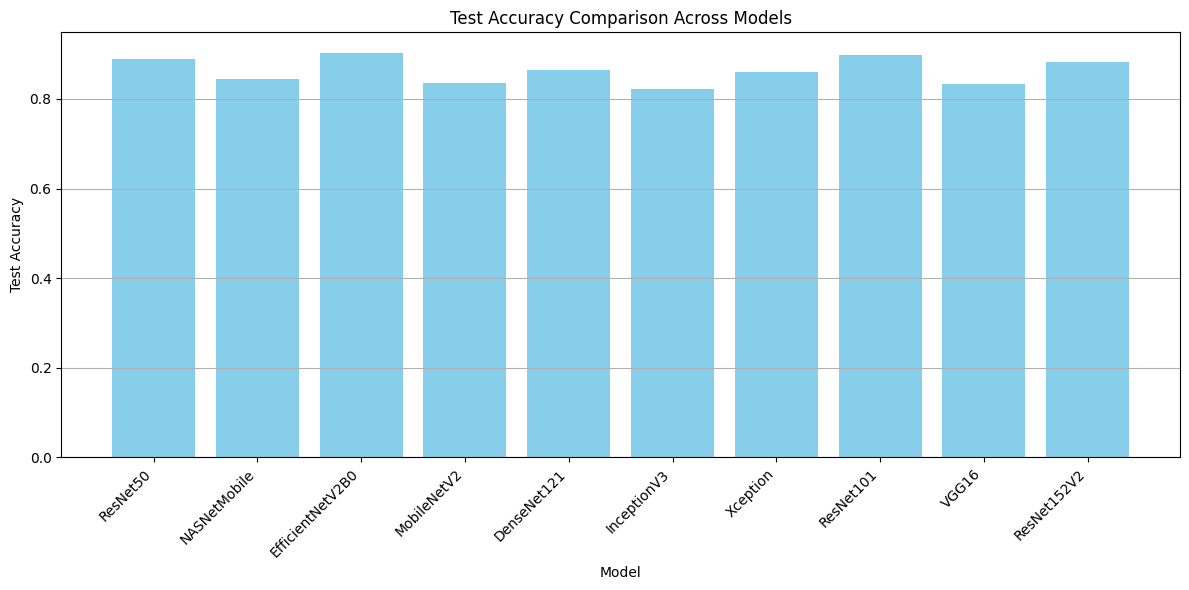

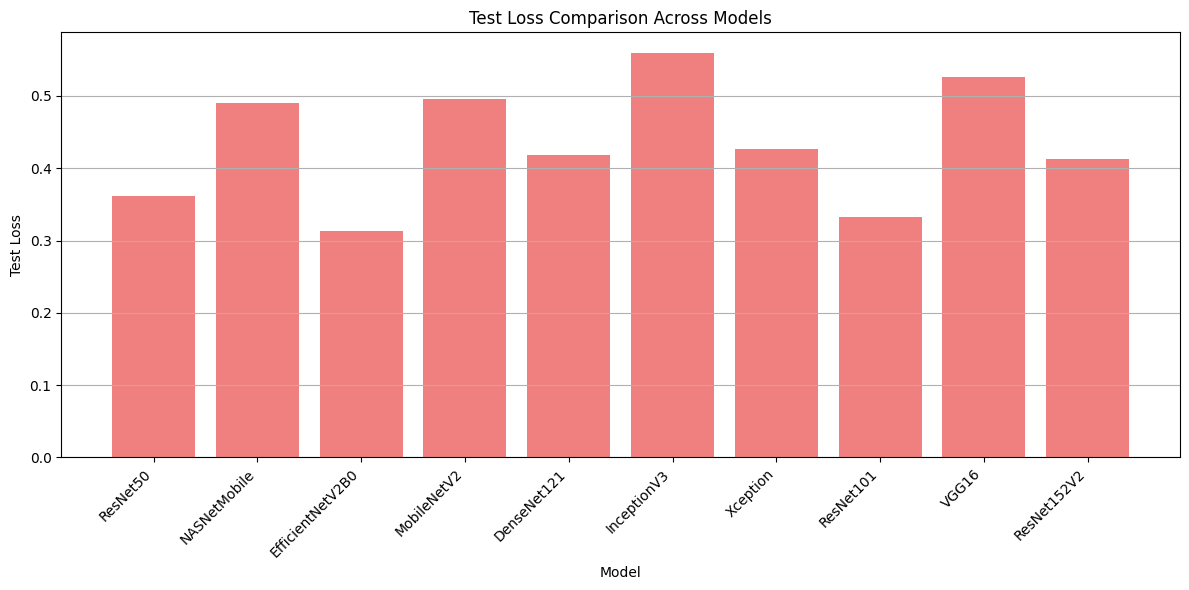

In [ ]:
s